
# Hybrid **CNN–LSTM**


In [ ]:
# === Configuración inicial ===
from pathlib import Path

DATA_PATH  = Path("../data/processed/ddos_findef.csv")
TARGET_COL = "y"
FEATURES   = None
SEQ_LEN    = 20         # largo de ventana
SEQ_STRIDE = 5          # salto entre ventanas
GROUP_BY   = None       # si tienes un ID de flujo/sesión, ponlo aquí. Si None, se usa orden temporal global

VAL_SIZE   = 0.2
TEST_SIZE  = 0.2
RANDOM_STATE = 42

print("Ruta de datos:", DATA_PATH)

Ruta de datos: ../data/processed/ddos_findef.csv


## 1. Carga y construcción de secuencias

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(DATA_PATH)

if TARGET_COL not in df.columns:
    raise ValueError(f"No encuentro '{TARGET_COL}'. Columnas disponibles: {list(df.columns)[:20]} ...")

# Orden temporal
time_col = None
for c in df.columns:
    if "time" in c.lower() or "timestamp" in c.lower():
        time_col = c; break

if time_col:
    df = df.sort_values(by=time_col).reset_index(drop=True)
else:
    df = df.reset_index(drop=True)

# Selección de features
if FEATURES is None:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    FEATURES = [c for c in num_cols if c != TARGET_COL]

X_tab = df[FEATURES].astype(float).values
y_all = df[TARGET_COL].astype(int).values

print("Total filas:", len(df), "| Features:", len(FEATURES))

Total filas: 2660377 | Features: 19


In [ ]:
# Función de ventaneo
def build_sequences(X, y, seq_len=20, stride=5):
    xs, ys = [], []
    for start in range(0, len(X) - seq_len + 1, stride):
        end = start + seq_len
        xs.append(X[start:end])
        ys.append(y[end-1])
    return np.array(xs), np.array(ys)

X_seq, y_seq = build_sequences(X_tab, y_all, SEQ_LEN, SEQ_STRIDE)
print("Secuencias:", X_seq.shape, "| Labels:", y_seq.shape)

Secuencias: (532072, 20, 19) | Labels: (532072,)


## 2. Partición Train/Val/Test

In [ ]:
from sklearn.model_selection import train_test_split

# Primero separamos test del final (temporalmente consistente si venimos ordenados)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_seq, y_seq, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_seq
)

# Luego validación
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=VAL_SIZE/(1-TEST_SIZE),
    random_state=RANDOM_STATE, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
class_ratio = y_train.mean()
print(f"Positives ratio (train): {class_ratio:.4f}")

Train: (319242, 20, 19) Val: (106415, 20, 19) Test: (106415, 20, 19)
Positives ratio (train): 0.2089


## 3. Modelo Hybrid CNN–LSTM (Keras)
Arquitectura típica para secuencias numéricas: `Conv1D → BatchNorm → ReLU → LSTM → Dense`.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

tf.random.set_seed(RANDOM_STATE)

n_features = X_train.shape[-1]

inputs = layers.Input(shape=(X_train.shape[1], n_features))
x = layers.Conv1D(filters=64, kernel_size=3, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.LSTM(64, return_sequences=False)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Precision(name="precision"),
                       tf.keras.metrics.Recall(name="recall")])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 19)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 20, 64)         │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,665 (194.00 KB)

 Trainable params: 49,409 (193.00 KB)

 Non-trainable params: 256 (1.00 KB)


## 4) Entrenamiento con callbacks y class weights


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Class weights
cw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: cw[0], 1: cw[1]}
class_weights

{0: 0.6320422256363147, 1: 2.3933337331694005}

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=256,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 45s 35ms/step - auc: 0.9209 - loss: 0.3415 - precision: 0.6228 - recall: 0.8470 - val_auc: 0.9727 - val_loss: 0.1959 - val_precision: 0.7802 - val_recall: 0.9164 - learning_rate: 0.0010
Epoch 2/60
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - auc: 0.9727 - loss: 0.2014 - precision: 0.8013 - recall: 0.9214 - val_auc: 0.9824 - val_loss: 0.1306 - val_precision: 0.8817 - val_recall: 0.9110 - learning_rate: 0.0010
Epoch 3/60
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - auc: 0.9827 - loss: 0.1556 - precision: 0.8471 - recall: 0.9402 - val_auc: 0.9659 - val_loss: 0.2153 - val_precision: 0.9417 - val_recall: 0.6244 - learning_rate: 0.0010
Epoch 4/60
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - auc: 0.9858 - loss: 0.1386 - precision: 0.8607 - recall: 0.9485 - val_auc: 0.9745 - val_loss: 0.1726 - val_precision: 0.9586 - val_recall: 0.7069 - learning_rate: 0.0010
Epoch 5/60
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - auc: 0.9879 - loss: 0.1269 - p


## 5) Curvas de aprendizaje (history)


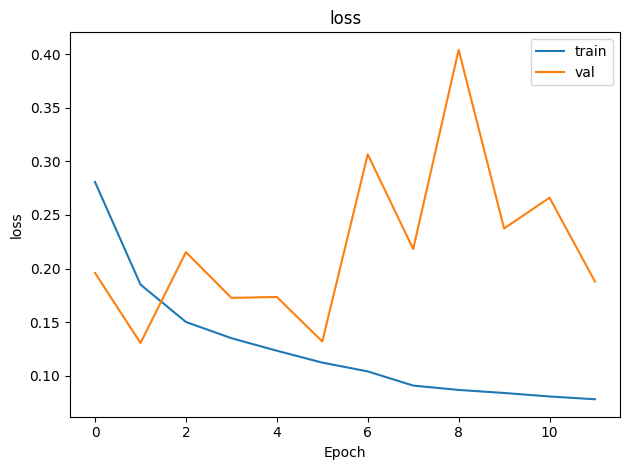

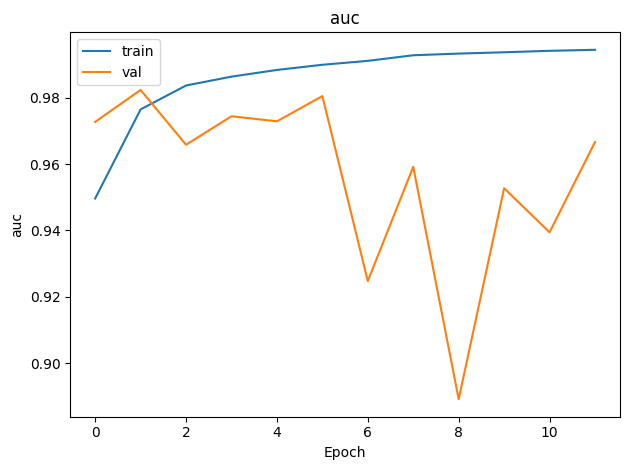

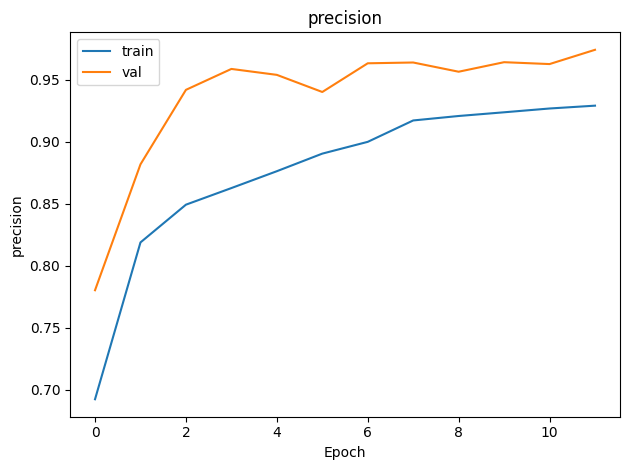

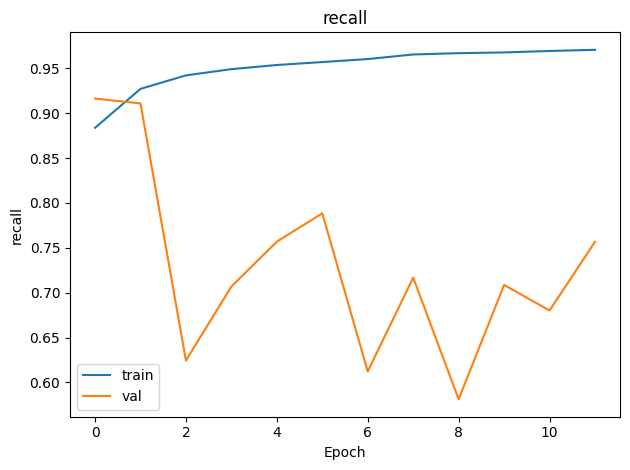

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, keys=("loss","auc")):
    for k in keys:
        fig = plt.figure()
        plt.plot(hist.history[k])
        plt.plot(hist.history.get("val_"+k, []))
        plt.xlabel("Epoch"); plt.ylabel(k)
        plt.title(k)
        plt.legend(["train", "val"])
        plt.tight_layout()
        plt.show()

plot_history(history, keys=("loss","auc","precision","recall"))

## 6. Evaluación en Test y calibración (Temperature Scaling)

3326/3326 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Test ROC AUC: 0.9823 | PR AUC: 0.9527

Classification report:
               precision    recall  f1-score   support

           0     0.9755    0.9674    0.9714     84183
           1     0.8803    0.9079    0.8939     22232

    accuracy                         0.9550    106415
   macro avg     0.9279    0.9377    0.9327    106415
weighted avg     0.9556    0.9550    0.9552    106415



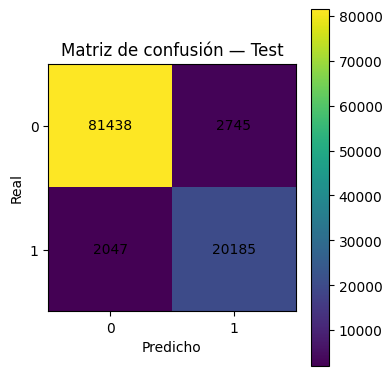

Brier (sin calibrar): 0.035563941945854265


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, brier_score_loss
import numpy as np

proba_test = model.predict(X_test).ravel()
roc_auc = roc_auc_score(y_test, proba_test)
pr_auc  = average_precision_score(y_test, proba_test)
print(f"Test ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f}")

pred_test = (proba_test >= 0.5).astype(int)
print("\nClassification report:\n", classification_report(y_test, pred_test, digits=4))

cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión — Test")
plt.colorbar()
plt.xticks([0,1],[0,1]); plt.yticks([0,1],[0,1])
plt.xlabel("Predicho"); plt.ylabel("Real")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,cm[i,j],ha="center",va="center")
plt.tight_layout(); plt.show()

brier = brier_score_loss(y_test, proba_test)
print("Brier (sin calibrar):", brier)

In [ ]:
# Temperature Scaling
import tensorflow as tf

val_logits = tf.math.log(model.predict(X_val).ravel() / (1 - model.predict(X_val).ravel() + 1e-12) + 1e-12)
test_logits = tf.math.log(proba_test / (1 - proba_test + 1e-12) + 1e-12)

T = tf.Variable(1.0, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

def nll_with_temperature(T):
    logits = val_logits / T
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_val.astype("float32"), logits=logits))

for _ in range(200):
    with tf.GradientTape() as tape:
        loss = nll_with_temperature(T)
    grads = tape.gradient(loss, [T])
    optimizer.apply_gradients(zip(grads, [T]))

T_opt = float(T.numpy())
print("Temperatura óptima:", T_opt)

# Calibrar test
cal_proba_test = tf.sigmoid(test_logits / T_opt).numpy()

3326/3326 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3326/3326 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Temperatura óptima: 0.8578944206237793



## 7) Confiabilidad, Brier y ECE (antes vs después)


ECE antes: 0.024381 | ECE después: 0.015389
Brier antes: 0.035564 | Brier después: 0.035487


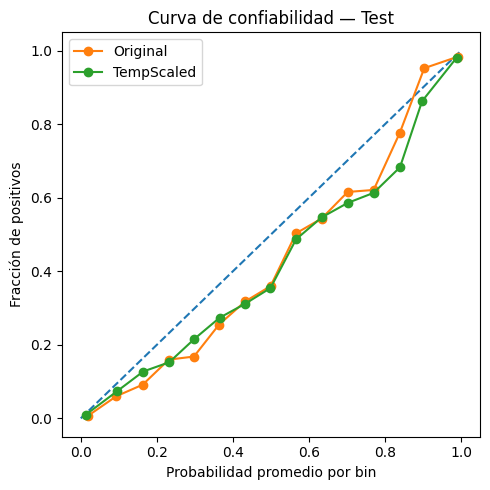

In [ ]:
from sklearn.calibration import calibration_curve

def expected_calibration_error(y_true, y_prob, n_bins=15):
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    bins = np.linspace(0,1,n_bins+1); ece=0.0; total=len(y_true)
    for i in range(n_bins):
        l,r=bins[i],bins[i+1]
        mask=(y_prob>=l)&(y_prob<(r if i<n_bins-1 else r))
        if np.any(mask):
            acc=y_true[mask].mean(); conf=y_prob[mask].mean()
            ece += abs(acc-conf)*(mask.sum()/total)
    return ece

ece_before = expected_calibration_error(y_test, proba_test, 15)
ece_after  = expected_calibration_error(y_test, cal_proba_test, 15)
from sklearn.metrics import brier_score_loss
brier_before = brier_score_loss(y_test, proba_test)
brier_after  = brier_score_loss(y_test, cal_proba_test)
print(f"ECE antes: {ece_before:.6f} | ECE después: {ece_after:.6f}")
print(f"Brier antes: {brier_before:.6f} | Brier después: {brier_after:.6f}")

# Reliability curves
fig = plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],"--")
for name, p in {"Original": proba_test, "TempScaled": cal_proba_test}.items():
    frac_pos, mean_pred = calibration_curve(y_test, p, n_bins=15, strategy="uniform")
    plt.plot(mean_pred, frac_pos, marker="o", label=name)
plt.xlabel("Probabilidad promedio por bin"); plt.ylabel("Fracción de positivos")
plt.title("Curva de confiabilidad — Test")
plt.legend(); plt.tight_layout(); plt.show()

## 8. Interpretabilidad: Integrated Gradients (básico) y SHAP Deep (opcional)

Ejecutando KernelExplainer (esto será lento)...
Calculando SHAP values para 5 muestras... (Esto puede tardar varios minutos)


  0%|          | 0/5 [00:00<?, ?it/s]

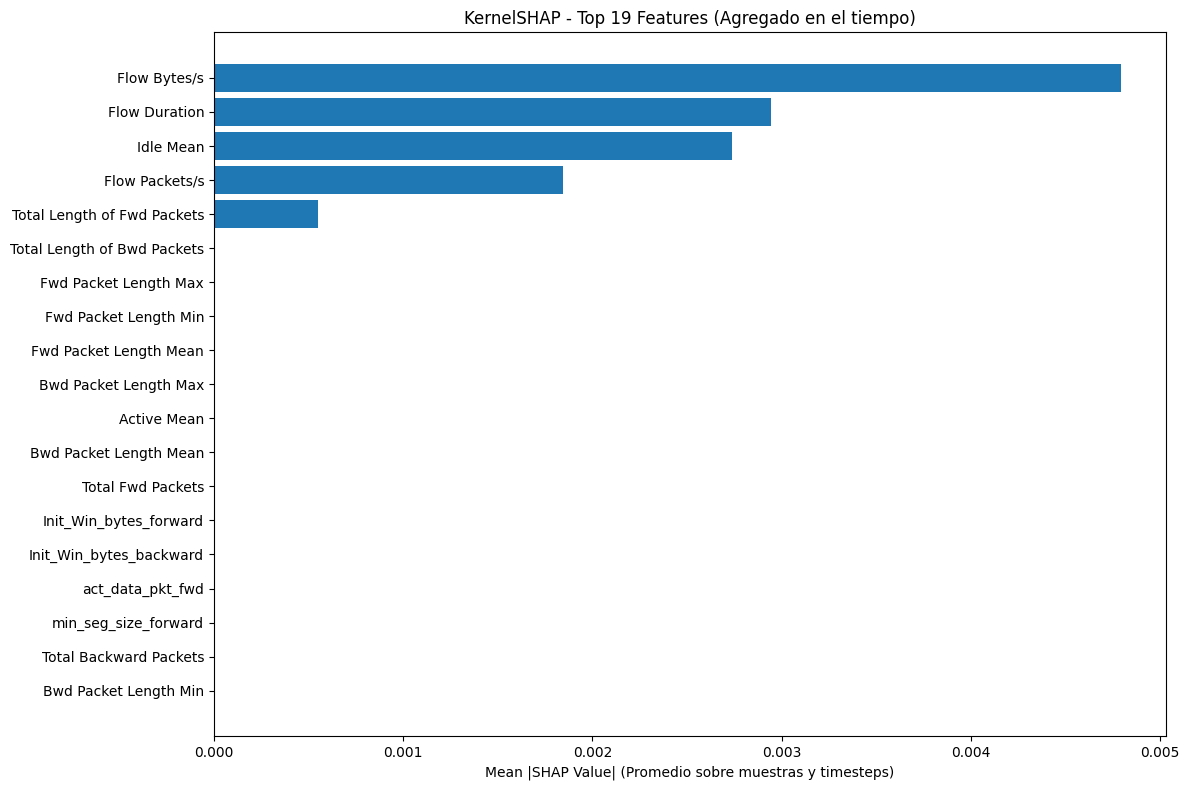

Top 19 Features por SHAP:
 1. Flow Bytes/s: 0.004793
 2. Flow Duration: 0.002945
 3. Idle Mean: 0.002736
 4. Flow Packets/s: 0.001845
 5. Total Length of Fwd Packets: 0.000549
 6. Total Length of Bwd Packets: 0.000000
 7. Fwd Packet Length Max: 0.000000
 8. Fwd Packet Length Min: 0.000000
 9. Fwd Packet Length Mean: 0.000000
10. Bwd Packet Length Max: 0.000000
11. Active Mean: 0.000000
12. Bwd Packet Length Mean: 0.000000
13. Total Fwd Packets: 0.000000
14. Init_Win_bytes_forward: 0.000000
15. Init_Win_bytes_backward: 0.000000
16. act_data_pkt_fwd: 0.000000
17. min_seg_size_forward: 0.000000
18. Total Backward Packets: 0.000000
19. Bwd Packet Length Min: 0.000000


In [ ]:
try:
    import shap
    import matplotlib.pyplot as plt
    import numpy as np
    import tensorflow as tf

    # === 1. DEFINIR LOS NOMBRES DE LAS FEATURES ===
    # Basado en tu dataset, estas son las 19 columnas de features 
    FEATURES = [
        'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
        'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
        'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
        'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
        'Flow Bytes/s', 'Flow Packets/s', 'Init_Win_bytes_forward',
        'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward',
        'Active Mean', 'Idle Mean'
    ]
    
    print("Ejecutando KernelExplainer (esto será lento)...")
    
    # 2. Obtener las dimensiones originales
    SEQ_LEN = X_train.shape[1]    # 20
    N_FEATURES = X_train.shape[2] # 19
    N_FEATURES_FLAT = SEQ_LEN * N_FEATURES # 380

    # 3. Crear la función wrapper
    def predict_fn_wrapper(x_flattened):
        n_samples = x_flattened.shape[0]
        x_3d = x_flattened.reshape(n_samples, SEQ_LEN, N_FEATURES)
        return model.predict(x_3d, verbose=0)

    # 4. Preparar los datos de fondo (background) y de prueba (test)
    # Deben estar aplanados a 2D
    background_3d = X_train[:50]
    background_2d = background_3d.reshape(-1, N_FEATURES_FLAT)
    background_summary_2d = shap.kmeans(background_2d, 10) 

    test_samples_3d = X_test[:5]
    test_samples_2d = test_samples_3d.reshape(-1, N_FEATURES_FLAT)

    # 5. Inicializar KernelExplainer
    explainer = shap.KernelExplainer(predict_fn_wrapper, background_summary_2d)
    
    # 6. Calcular SHAP values
    print(f"Calculando SHAP values para {test_samples_2d.shape[0]} muestras... (Esto puede tardar varios minutos)")
    shap_values = explainer.shap_values(test_samples_2d)
    
    # 7. Procesar resultados
    shap_values_class1 = shap_values[1] # Tomar clase 1
    shap_values_3d = shap_values_class1.reshape(-1, SEQ_LEN, N_FEATURES)

    # 8. Calcular importancia (promediar sobre eje 0 y 1)
    feature_importance = np.mean(np.abs(shap_values_3d), axis=(0, 1))

    # === 9. OBTENER NOMBRES DE FEATURES (Corregido) ===
    # Usar la lista definida arriba
    feature_names = FEATURES
    assert len(feature_names) == N_FEATURES, "La lista de features no coincide (esperaba 19)"

    # 10. Obtener Top 20
    top_n = min(len(feature_names), N_FEATURES) # Usar el número real de features
    top_indices = np.argsort(-feature_importance)[:top_n]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = feature_importance[top_indices]
    
    # 11. Graficar
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_importance[::-1])
    plt.yticks(range(len(top_features)), top_features[::-1])
    plt.title(f'KernelSHAP - Top {top_n} Features (Agregado en el tiempo)')
    plt.xlabel('Mean |SHAP Value| (Promedio sobre muestras y timesteps)')
    plt.tight_layout()
    plt.show()
    
    # 12. Mostrar tabla
    print(f"Top {top_n} Features por SHAP:")
    for i, (name, imp) in enumerate(zip(top_features, top_importance)):
        print(f"{i+1:2d}. {name}: {imp:.6f}")

except Exception as e:
    # Capturar cualquier otro error
    print(f"SHAP falló: {e}")